In [1]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import sem
from scipy.stats import linregress



# Data Load/Setup

In [2]:
# Import CSV files
#Files currently being used
emissions_df = pd.read_csv('Resources/co2_emissions_kt_by_country.csv')
pesticide_df = pd.read_csv('Resources/pesticide-use-tonnes.csv')
population_df = pd.read_csv('Resources/population.csv')

#CSV files from land folder needs cleaning
land_allotment_df = pd.read_csv('Resources/Land/agr_land_percent.csv')
total_land_df = pd.read_csv('Resources/Land/total-land.csv')

#CSV file on crop yields, needs cleaning for ease of use
crop_yields_df = pd.read_csv('Resources/crop_yields.csv')

#CSV files for GDP
agShare_df = pd.read_csv('Resources/agriculture-share-gdp.csv')
gdp_df = pd.read_csv('Resources/national-gdp-penn-world-table.csv')


# cc_Impact_Agri_df = pd.read_csv('Resources/climate_change_impact_on_agriculture_2024.csv')
# agroFood_df = pd.read_csv('Resources/Agrofood_co2_emission.csv')
# owid_co2_c_df = pd.read_csv('Resources/owid-co2-data.csv')


In [30]:
#Merging GDP basd dataframes
gdp_cleaned_df = pd.merge(gdp_df, agShare_df, how = 'left', left_on = ['Entity', 'Year', 'Code'], right_on = ['Entity', 'Year', 'Code']).dropna()
gdp_cleaned_df = gdp_cleaned_df.rename(columns = {'GDP (output, multiple price benchmarks)': 'GDP',
                                                  'Agriculture, forestry, and fishing, value added (% of GDP)': 'Ag% of GDP'})
gdp_cleaned_df

,Entity,Code,Year,GDP,Ag% of GDP
25,Albania,ALB,1996,15067375000,36.410862
26,Albania,ALB,1997,14072310000,31.543444
27,Albania,ALB,1998,15531704000,28.785650
28,Albania,ALB,1999,16525398000,25.918745
29,Albania,ALB,2000,16633271000,24.515411
...,...,...,...,...,...
10103,Zimbabwe,ZWE,2015,39798645000,8.284246
10104,Zimbabwe,ZWE,2016,40963190000,7.873986
10105,Zimbabwe,ZWE,2017,44316740000,8.340969
10106,Zimbabwe,ZWE,2018,43420897000,7.319375


In [3]:
# Merge the dataframes
df = pd.merge(emissions_df, pesticide_df, how = "left", left_on = ['country_code','year'], right_on = ['Code','Year']).dropna()
df = df.drop(columns = ["Entity", "Code", "Year"])
df = df.rename(columns = {
    "country_name": "country",
    "value": "co2_emissions",
    "Pesticides (total) | 00001357 || Agricultural Use | 005157 || Tonnes": "pesticide_by_tonnes"
})
df = pd.merge(df, agShare_df, how = "left", left_on = ['country_code','year'], right_on = ['Code','Year']).dropna()
df = df.drop(columns = ["Entity", "Code", "Year"])
df = df.rename(columns = {
    "Agriculture, forestry, and fishing, value added (% of GDP)": "ag_percent_gdp"
})
df = pd.merge(df, population_df, how = "left", left_on = ['country_code','year'], right_on = ['Code','Year']).dropna()
df = df.drop(columns = ["Entity", "Code", "Year"])
df = df.rename(columns = {
    "Population (historical)": "population"
})
df = pd.merge(df, gdp_df, how = "left", left_on = ['country_code','year'], right_on = ['Code','Year']).dropna()
df = df.drop(columns = ["Entity", "Code", "Year"])
df = df.rename(columns = {
    "GDP (output, multiple price benchmarks)": "gdp"
})

# Print information about the merged dataframe and the head of the datafram
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4597 entries, 0 to 5086
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country_code         4597 non-null   object 
 1   country              4597 non-null   object 
 2   year                 4597 non-null   int64  
 3   co2_emissions        4597 non-null   float64
 4   pesticide_by_tonnes  4597 non-null   float64
 5   ag_percent_gdp       4597 non-null   float64
 6   population           4597 non-null   int64  
 7   gdp                  4597 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 323.2+ KB


,country_code,country,year,co2_emissions,pesticide_by_tonnes,ag_percent_gdp,population,gdp
0,ABW,Aruba,1995,707.731,231.75,0.505922,75931,4.184156e+09
1,ABW,Aruba,1996,726.066,252.64,0.485830,78495,3.977093e+09
2,ABW,Aruba,1997,759.069,273.52,0.429978,81121,4.282010e+09
3,ABW,Aruba,1998,806.740,294.41,0.407917,83787,4.660577e+09
4,ABW,Aruba,1999,810.407,315.30,0.383268,86482,4.854151e+09


In [4]:
# Commented out in case needed for later

# # Merge dataframes: emissions_df, pesticide_use_df, population_df
# df = pd.merge(emissions_df, pesticide_use_df, how = "left", left_on = ['country_code','year'], right_on = ['Code','Year']).dropna()
# df = df.rename(columns = {
#     "country_name": "country",
#     "value": "co2_emissions",
#     "Pesticides (total) | 00001357 || Agricultural Use | 005157 || Tonnes": "pesticide_by_tonnes"
# })
# df = df.drop(columns = ['Entity', 'Code', 'Year'])
# df = pd.merge(df, population_df, how = "left", left_on = ['country_code','year'], right_on = ['Code','Year']).dropna()
# # df = df.drop(columns = ["Entity", "Code", "Year"])
# df = df.rename(columns = {
#     "Population (historical)": "population"
# })
# df = df.drop(columns = ['Entity', 'Code', 'Year'])
# df

In [5]:
# Modifying agricultural land allotment df
land_holder = land_allotment_df.drop(columns = ['Indicator Name', 'Country Code', 'Indicator Code'])


df_long = pd.melt(land_holder, id_vars=['Country Name'], var_name = 'year', value_name ='% of Agricultural Land')
df_long.rename(columns={'Country Name': 'country'}, inplace=True)
df_long_sorted_df = df_long.sort_values(by=['country', 'year'])
df_long_sorted_df = df_long_sorted_df.reset_index(drop = True)

indicies_to_drop = df_long_sorted_df[df_long_sorted_df['year'] == 'Unnamed: 68'].index
df_long_sorted_df.drop(index = indicies_to_drop, inplace=True)

df_long_sorted_df['year'] = df_long_sorted_df['year'].astype(np.int64)
land_agri_final_df = df_long_sorted_df
land_agri_final_df

,country,year,% of Agricultural Land
0,Afghanistan,1960,NaN
1,Afghanistan,1961,57.878356
2,Afghanistan,1962,57.955016
3,Afghanistan,1963,58.031676
4,Afghanistan,1964,58.116002
...,...,...,...
17284,Zimbabwe,2019,41.876696
17285,Zimbabwe,2020,41.876696
17286,Zimbabwe,2021,41.876696
17287,Zimbabwe,2022,NaN


In [6]:
#Modifying total_land_df
total_land_df
land_holder = total_land_df.drop(columns = ['Indicator Name', 'Country Code', 'Indicator Code'])


df_long = pd.melt(land_holder, id_vars=['Country Name'], var_name = 'year', value_name ='Total Land (sq.km)')
df_long.rename(columns={'Country Name': 'country'}, inplace=True)
df_long_sorted_df = df_long.sort_values(by=['country', 'year'])
df_long_sorted_df = df_long_sorted_df.reset_index(drop = True)

indicies_to_drop = df_long_sorted_df[df_long_sorted_df['year'] == 'Unnamed: 68'].index
df_long_sorted_df.drop(index = indicies_to_drop, inplace=True)

df_long_sorted_df['year'] = df_long_sorted_df['year'].astype(np.int64)
total_land_final_df = df_long_sorted_df
total_land_final_df

,country,year,Total Land (sq.km)
0,Afghanistan,1960,NaN
1,Afghanistan,1961,652230.0
2,Afghanistan,1962,652230.0
3,Afghanistan,1963,652230.0
4,Afghanistan,1964,652230.0
...,...,...,...
17284,Zimbabwe,2019,386850.0
17285,Zimbabwe,2020,386850.0
17286,Zimbabwe,2021,386850.0
17287,Zimbabwe,2022,NaN


In [7]:
#Merging total_land_final_df and land_agri_final_df into land_df
land_df = pd.merge(total_land_final_df, land_agri_final_df, how = 'left', left_on = ['country', 'year'], right_on = ['country', 'year']).dropna()
land_df['Agricultural Land (sq.km)'] = land_df['Total Land (sq.km)'] * land_df['% of Agricultural Land']
land_df


,country,year,Total Land (sq.km),% of Agricultural Land,Agricultural Land (sq.km)
1,Afghanistan,1961,652230.0,57.878356,37750000.0
2,Afghanistan,1962,652230.0,57.955016,37800000.0
3,Afghanistan,1963,652230.0,58.031676,37850000.0
4,Afghanistan,1964,652230.0,58.116002,37905000.0
5,Afghanistan,1965,652230.0,58.123668,37910000.0
...,...,...,...,...,...
17017,Zimbabwe,2017,386850.0,41.876696,16200000.0
17018,Zimbabwe,2018,386850.0,41.876696,16200000.0
17019,Zimbabwe,2019,386850.0,41.876696,16200000.0
17020,Zimbabwe,2020,386850.0,41.876696,16200000.0


In [9]:
#Merging main df with % of agricultural land df
main_df = pd.merge(df, land_df, how = 'left', left_on = ['country', 'year'], right_on = ['country', 'year']).dropna()
main_df


,country_code,country,year,co2_emissions,pesticide_by_tonnes,ag_percent_gdp,population,gdp,Total Land (sq.km),% of Agricultural Land,Agricultural Land (sq.km)
0,ABW,Aruba,1995,707.731000,231.75,0.505922,75931,4.184156e+09,180.0,11.111111,2000.0
1,ABW,Aruba,1996,726.066000,252.64,0.485830,78495,3.977093e+09,180.0,11.111111,2000.0
2,ABW,Aruba,1997,759.069000,273.52,0.429978,81121,4.282010e+09,180.0,11.111111,2000.0
3,ABW,Aruba,1998,806.740000,294.41,0.407917,83787,4.660577e+09,180.0,11.111111,2000.0
4,ABW,Aruba,1999,810.407000,315.30,0.383268,86482,4.854151e+09,180.0,11.111111,2000.0
...,...,...,...,...,...,...,...,...,...,...,...
4592,ZWE,Zimbabwe,2015,12430.000305,2185.07,8.284246,14399009,3.979864e+10,386850.0,41.876696,16200000.0
4593,ZWE,Zimbabwe,2016,11020.000458,2185.07,7.873986,14600297,4.096319e+10,386850.0,41.876696,16200000.0
4594,ZWE,Zimbabwe,2017,10340.000153,2185.07,8.340969,14812484,4.431674e+10,386850.0,41.876696,16200000.0
4595,ZWE,Zimbabwe,2018,12380.000114,2185.07,7.319375,15034457,4.342090e+10,386850.0,41.876696,16200000.0


In [10]:
# Modifying crop_yields_df so that it shows sum crop yield within each country's year
# Note: crop yields are in tonnes per hecatare
crop_yields_df
test_crop_df = crop_yields_df
all_columns = crop_yields_df.columns.tolist()
crop_columns = all_columns[2:]
crop_yields_df['Total_Crop_Yield'] = crop_yields_df[crop_columns].sum(axis=1)

crop_yields_df = test_crop_df.drop(columns=crop_columns)
crop_yields_df

,country,year,Total_Crop_Yield
0,Afghanistan,1961,497.218199
1,Afghanistan,1962,500.500606
2,Afghanistan,1963,500.690099
3,Afghanistan,1964,508.990498
4,Afghanistan,1965,517.870401
...,...,...,...
14572,Zimbabwe,2018,780.655493
14573,Zimbabwe,2019,777.940795
14574,Zimbabwe,2020,778.620694
14575,Zimbabwe,2021,778.041794


In [11]:
#Merging main df with crop_yields_df
main_df = pd.merge(main_df, crop_yields_df, how = 'left', left_on = ['country', 'year'], right_on = ['country', 'year']).dropna()
main_df = main_df.reset_index(drop = True)
main_df

,country_code,country,year,co2_emissions,pesticide_by_tonnes,ag_percent_gdp,population,gdp,Total Land (sq.km),% of Agricultural Land,Agricultural Land (sq.km),Total_Crop_Yield
0,AGO,Angola,1995,12720.000000,336.00,6.653213,13699780,3.198311e+10,1246700.0,35.686212,44490000.0,520.982797
1,AGO,Angola,1996,15440.000000,40.00,7.026869,14170973,4.062082e+10,1246700.0,35.651721,44447000.0,521.433292
2,AGO,Angola,1997,16160.000000,40.00,9.002018,14660420,4.178232e+10,1246700.0,35.654127,44450000.0,521.394493
3,AGO,Angola,1998,16770.000000,40.00,12.911182,15159377,4.394571e+10,1246700.0,35.704660,44513000.0,523.105696
4,AGO,Angola,1999,17610.000000,40.00,6.290257,15667234,4.279030e+10,1246700.0,35.747975,44567000.0,522.281093
...,...,...,...,...,...,...,...,...,...,...,...,...
3931,ZWE,Zimbabwe,2015,12430.000305,2185.07,8.284246,14399009,3.979864e+10,386850.0,41.876696,16200000.0,775.884894
3932,ZWE,Zimbabwe,2016,11020.000458,2185.07,7.873986,14600297,4.096319e+10,386850.0,41.876696,16200000.0,777.129893
3933,ZWE,Zimbabwe,2017,10340.000153,2185.07,8.340969,14812484,4.431674e+10,386850.0,41.876696,16200000.0,774.345388
3934,ZWE,Zimbabwe,2018,12380.000114,2185.07,7.319375,15034457,4.342090e+10,386850.0,41.876696,16200000.0,780.655493


In [13]:
# Isolate United States as test 
us_df = main_df[main_df['country'] == 'United States']
us_df

,country_code,country,year,co2_emissions,pesticide_by_tonnes,ag_percent_gdp,population,gdp,Total Land (sq.km),% of Agricultural Land,Agricultural Land (sq.km),Total_Crop_Yield
3823,USA,United States,1997,5.543350e+06,434540.75,1.336912,273468014,1.236025e+13,9158960.0,45.298265,414885000.0,1859.612087
3824,USA,United States,1998,5.590540e+06,424562.12,1.213997,276119323,1.292432e+13,9158960.0,45.265838,414588000.0,1787.436981
3825,USA,United States,1999,5.609020e+06,433633.97,1.151241,278785482,1.352682e+13,9158960.0,45.189301,413887000.0,1839.230788
3826,USA,United States,2000,5.775810e+06,430005.22,1.150555,281484127,1.409597e+13,9161920.0,45.230585,414399000.0,1980.223079
3827,USA,United States,2001,5.748260e+06,411407.94,1.129257,284279629,1.420542e+13,9161920.0,45.290070,414944000.0,1894.043390
3828,USA,United States,2002,5.593030e+06,416851.03,0.973712,287084336,1.439694e+13,9161920.0,45.084873,413064000.0,1881.292587
3829,USA,United States,2003,5.658990e+06,417758.25,1.121048,289908091,1.479968e+13,9161920.0,45.080322,413022300.0,1919.311581
3830,USA,United States,2004,5.738290e+06,425015.72,1.265484,292786247,1.537260e+13,9161920.0,45.075803,412980900.0,1992.187707
3831,USA,United States,2005,5.753490e+06,388275.16,1.150507,295716665,1.592055e+13,9161920.0,45.071295,412939600.0,1912.990081
3832,USA,United States,2006,5.653080e+06,392810.66,1.009487,298730210,1.638653e+13,9161920.0,45.066842,412898800.0,1951.870377


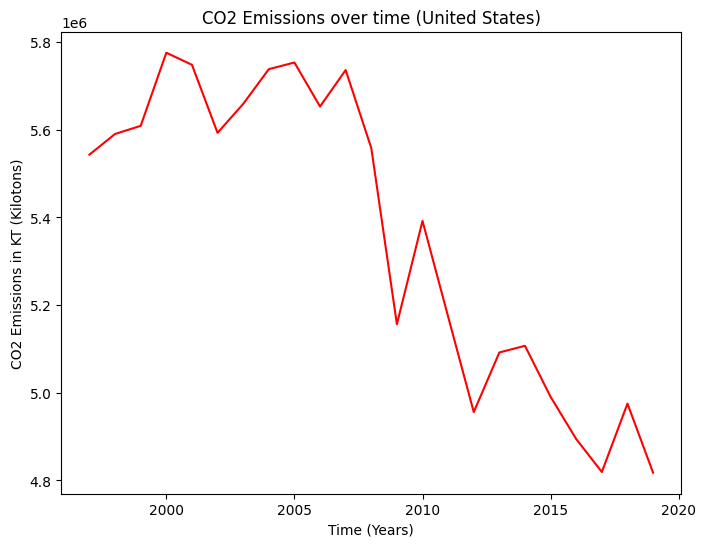

In [14]:
#plot of co2 emissions over time in United States
plt.figure(figsize=(8,6))

plt.plot(us_df['year'], us_df['co2_emissions'], linestyle='-',
         color='red')
plt.title('CO2 Emissions over time (United States)')
plt.xlabel('Time (Years)')
plt.ylabel('CO2 Emissions in KT (Kilotons)')


plt.show()

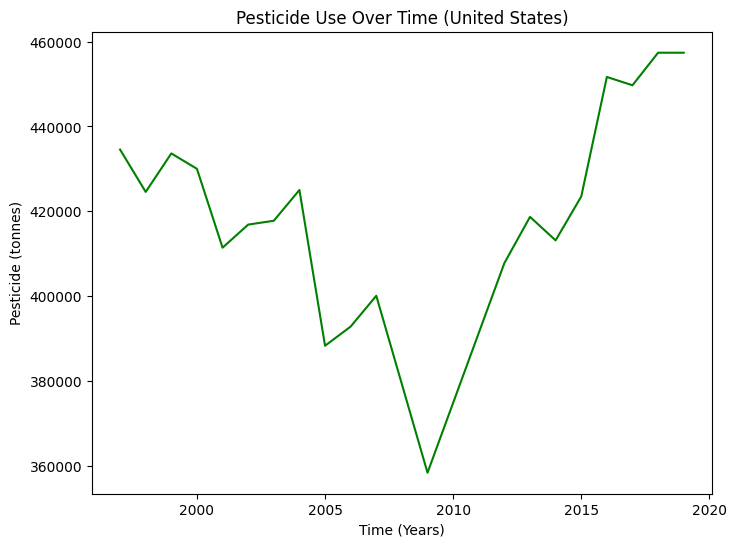

In [15]:
#United States Pesticide usage
plt.figure(figsize=(8,6))

plt.plot(us_df['year'], us_df['pesticide_by_tonnes'], linestyle='-',
         color='green')
plt.title('Pesticide Use Over Time (United States)')
plt.xlabel('Time (Years)')
plt.ylabel('Pesticide (tonnes)')

plt.show()

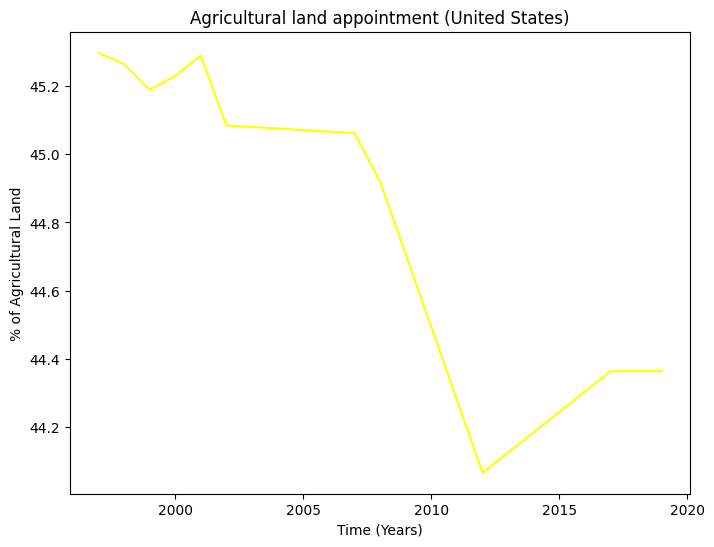

In [16]:
#United States agriculture land appointment
plt.figure(figsize=(8,6))

plt.plot(us_df['year'], us_df['% of Agricultural Land'], linestyle='-',
         color='yellow')
plt.title('Agricultural land appointment (United States)')
plt.xlabel('Time (Years)')
plt.ylabel('% of Agricultural Land')

plt.show()

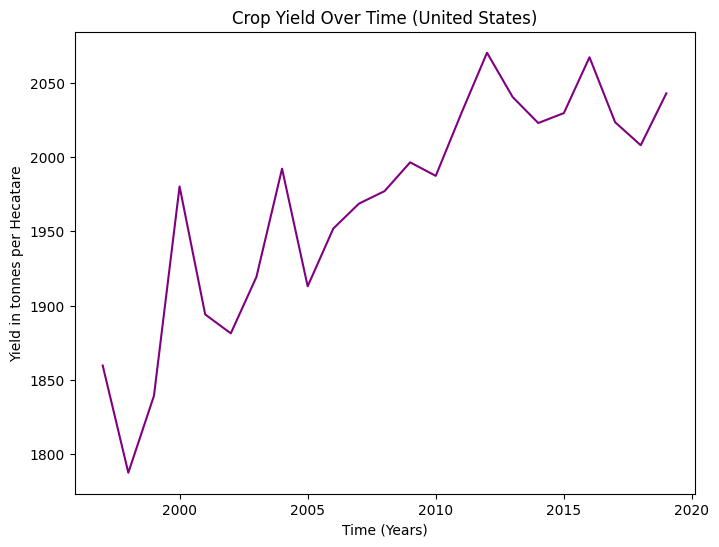

In [17]:
#United States crop yield over time
plt.figure(figsize=(8,6))

plt.plot(us_df['year'], us_df['Total_Crop_Yield'], linestyle='-',
         color='purple')
plt.title('Crop Yield Over Time (United States)')
plt.xlabel('Time (Years)')
plt.ylabel('Yield in tonnes per Hecatare')

plt.show()

The correlation between Agricultural Land assignment and CO2 Emissions is 0.08


<Figure size 800x600 with 0 Axes>

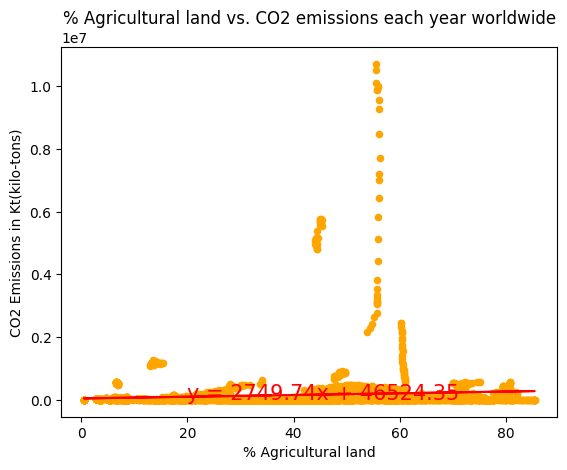

In [18]:
#Scatter plot of agri land vs co2 emi
main_df

#scatter plot of 
x_axis_world = main_df['% of Agricultural Land']
y_axis_world = main_df['co2_emissions']

correlation = st.pearsonr(x_axis_world,y_axis_world)
print(f"The correlation between Agricultural Land assignment and CO2 Emissions is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis_world, y_axis_world)
regress_values = x_axis_world * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(8,6))
main_df.plot.scatter(x='% of Agricultural Land', 
                             y='co2_emissions', color='orange')
plt.plot(x_axis_world,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="red")

plt.title('% Agricultural land vs. CO2 emissions each year worldwide')
plt.xlabel('% Agricultural land')
plt.ylabel('CO2 Emissions in Kt(kilo-tons)')


plt.show()

The correlation between land use and pesticide use is 0.03


<Figure size 800x600 with 0 Axes>

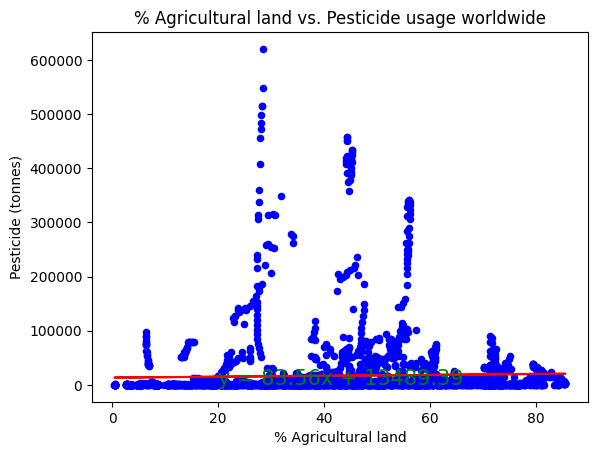

In [19]:
#Scatter plot of land vs pesticide
main_df

#scatter plot of 
x_axis_world = main_df['% of Agricultural Land']
y_axis_world = main_df['pesticide_by_tonnes']

correlation = st.pearsonr(x_axis_world,y_axis_world)
print(f"The correlation between land use and pesticide use is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis_world, y_axis_world)
regress_values = x_axis_world * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(8,6))
main_df.plot.scatter(x='% of Agricultural Land', 
                             y='pesticide_by_tonnes', color='blue')
plt.plot(x_axis_world,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="green")

plt.title('% Agricultural land vs. Pesticide usage worldwide')
plt.xlabel('% Agricultural land')
plt.ylabel('Pesticide (tonnes)')


plt.show()

The correlation between land use and population is 0.12


<Figure size 800x600 with 0 Axes>

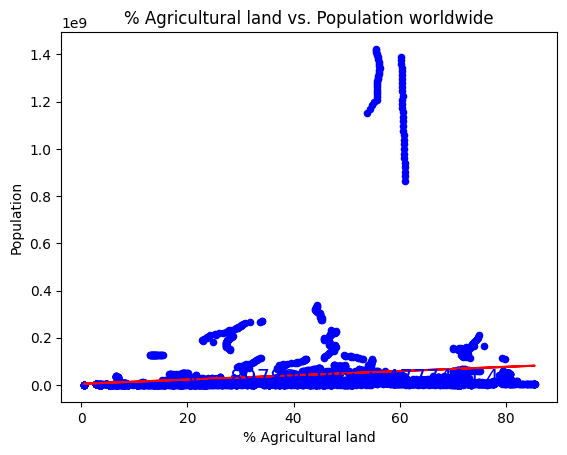

In [20]:
#Scatter plot of land vs pop
main_df
#scatter plot of 
x_axis_world = main_df['% of Agricultural Land']
y_axis_world = main_df['population']

correlation = st.pearsonr(x_axis_world,y_axis_world)
print(f"The correlation between land use and population is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis_world, y_axis_world)
regress_values = x_axis_world * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(8,6))
main_df.plot.scatter(x='% of Agricultural Land', 
                             y='population', color='blue')
plt.plot(x_axis_world,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="blue")

plt.title('% Agricultural land vs. Population worldwide')
plt.xlabel('% Agricultural land')
plt.ylabel('Population')

plt.show()

The correlation between land use and total crop yield is 0.06


<Figure size 800x600 with 0 Axes>

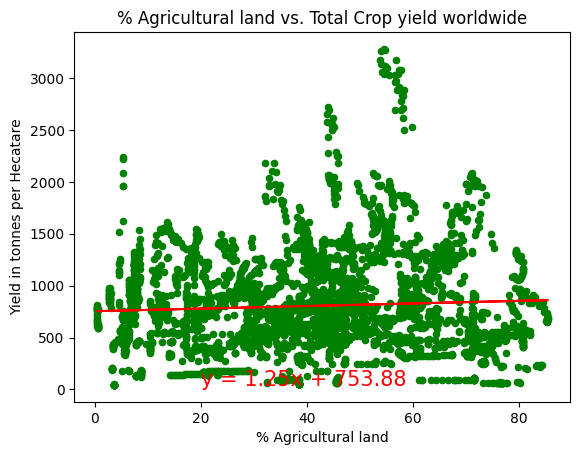

In [21]:
#Scatter plot of land vs total crop yield
main_df

#scatter plot of 
x_axis_world = main_df['% of Agricultural Land']
y_axis_world = main_df['Total_Crop_Yield']

correlation = st.pearsonr(x_axis_world,y_axis_world)
print(f"The correlation between land use and total crop yield is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis_world, y_axis_world)
regress_values = x_axis_world * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(8,6))
main_df.plot.scatter(x='% of Agricultural Land', 
                             y='Total_Crop_Yield', color='green')
plt.plot(x_axis_world,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="red")

plt.title('% Agricultural land vs. Total Crop yield worldwide')
plt.xlabel('% Agricultural land')
plt.ylabel('Yield in tonnes per Hecatare')


plt.show()


The correlation pesticide and co2 emissions is 0.71


<Figure size 800x600 with 0 Axes>

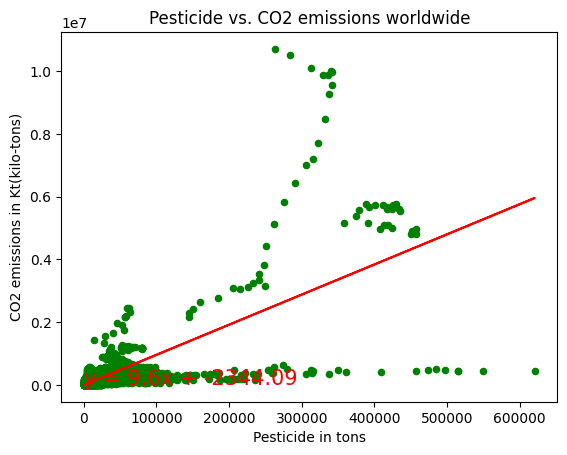

In [22]:
#Scatter plot of world wide pesticide versus co2

#scatter plot of 
x_axis_world = main_df['pesticide_by_tonnes']
y_axis_world = main_df['co2_emissions']

correlation = st.pearsonr(x_axis_world,y_axis_world)
print(f"The correlation pesticide and co2 emissions is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis_world, y_axis_world)
regress_values = x_axis_world * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(8,6))
main_df.plot.scatter(x='pesticide_by_tonnes', 
                             y='co2_emissions', color='green')
plt.plot(x_axis_world,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="red")

plt.title('Pesticide vs. CO2 emissions worldwide')
plt.xlabel('Pesticide in tons')
plt.ylabel('CO2 emissions in Kt(kilo-tons)')


plt.show()

The correlation between Pesticide Use and CO2 Emissions is 0.99


<Figure size 800x600 with 0 Axes>

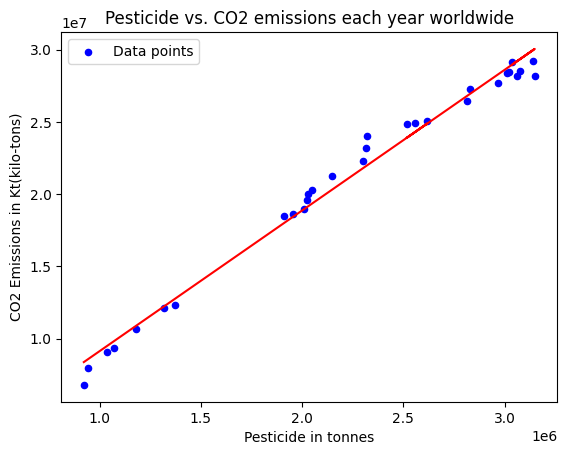

In [23]:
#Creating scatter plot using summation of all country's pesticide use per year by all 
#country's co2 emissions per year
main_df
grouped_holder_world = main_df.groupby('year').agg({'pesticide_by_tonnes': 'sum',
                                                             'co2_emissions': 'sum'})
world_grouped_df = grouped_holder_world.reset_index()
# world_grouped_df

#scatter plot of 
x_axis_world = world_grouped_df['pesticide_by_tonnes']
y_axis_world = world_grouped_df['co2_emissions']

correlation = st.pearsonr(x_axis_world,y_axis_world)
print(f"The correlation between Pesticide Use and CO2 Emissions is {round(correlation[0],2)}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis_world, y_axis_world)
regress_values = x_axis_world * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.figure(figsize=(8,6))
world_grouped_df.plot.scatter(x='pesticide_by_tonnes', 
                             y='co2_emissions', color='blue')
plt.plot(x_axis_world,regress_values,"r-")
plt.annotate(line_eq,(20,36),fontsize=15,color="red")

plt.title('Pesticide vs. CO2 emissions each year worldwide')
plt.xlabel('Pesticide in tonnes')
plt.ylabel('CO2 Emissions in Kt(kilo-tons)')

plt.legend(['Data points'])
plt.show()

In [24]:
#List of all country names in dataset
country_names = main_df["country"].unique()
country_names_list = country_names.tolist()
# country_names_list

In [ ]:
country_dict = {}
for _, row in country_grouped_df.iterrows():
    country = row['Country']
    year = row['Year']
    if country not in country_dict:
        country_dict[country] = {'Year': [], 'Pesticide_Use_KG_per_HA': [], 'CO2_Emissions_MT': []}
    country_dict[country]['Year'].append(year)
    country_dict[country]['Pesticide_Use_KG_per_HA'].append(row['Pesticide_Use_KG_per_HA'])
    country_dict[country]['CO2_Emissions_MT'].append(row['CO2_Emissions_MT'])